In [50]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_ollama import ChatOllama
from typing import TypedDict, Annotated
from dotenv import load_dotenv
load_dotenv()

True

In [51]:
# models
llm = ChatOllama(model='qwen3:8b')

In [52]:
# tools
search_tool = DuckDuckGoSearchRun()


@tool
def calculator(first_num: float, second_num: float, operation: str) -> dict:
    """
    Perform a basic arithmetic calculation on two numbers.
    Supported operations: add, sub, mul, div
    """
    try:
        if operation == "add":
            result = first_num + second_num
        elif operation == "sub":
            result = first_num - second_num
        elif operation == "mul":
            result = first_num * second_num
        elif operation == "div":
            result = first_num / second_num
        else:
            return {"error": f"Unsupported operation: {operation}"}

        return {"first_num": first_num, "second_num": second_num, "operation": operation, "result": result}
    except Exception as e:
        return {"error": str(e)}

In [53]:
# list of tools
tools = [search_tool, calculator]

In [54]:
# make the llm too-aware
llm_with_tools = llm.bind_tools(tools)

In [55]:
# state
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [56]:
def chat_node(state: ChatState):
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}


tools_node = ToolNode(tools)

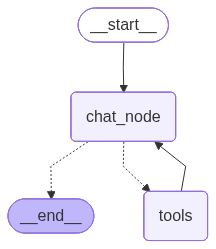

In [57]:
graph = StateGraph(ChatState)
# add nodes
graph.add_node("chat_node", chat_node)
graph.add_node("tools", tools_node)

# add edge
graph.add_edge(START, "chat_node")
graph.add_conditional_edges("chat_node", tools_condition)
graph.add_edge("tools", "chat_node")

# graph compile
chatbot = graph.compile()

chatbot

In [58]:
output = chatbot.invoke({'messages': [HumanMessage(content="what is 2 * 3")]})

In [59]:
print(output['messages'][-1].content)

The result of 2 multiplied by 3 is **6**.
